# Isometric Feature Mapping (ISOMAP)

Author: Andrei Vovk (copied Matt's MDS notebook)

[Overview](#linkOverview)  
[Resources](#linkResources)  
[Algorithm](#linkAlgorithm)  
[Example 1: Swiss Roll](#linkExample1)  
[Example 2: MNIST](#linkExample2)  
[Example 3: Faces](#linkExample3)  

## Overview <a id='linkOverview'></a>
- Non-linear dimensionality reduction technique  
- Assume that high dimensional data $X$ lies on a manifold, find a lower dimensional representation $Y$
- MDS where the metric is approximate manifold distance instead of euclidean

Weaknesses:
- "short-circuiting": false connections in the nearest neighour graph due to noise or short distance between folds
- manifolds with loops
- non-convex manifold?

## Resources <a id='linkResources'></a>
- 1998 https://web.mit.edu/cocosci/Papers/man_nips.pdf
- 2000 https://web.mit.edu/cocosci/Papers/sci_reprint.pdf
- variants http://web.mit.edu/cocosci/Papers/nips02-localglobal-in-press.pdf
- variant addressing loops https://perso.uclouvain.be/michel.verleysen/papers/neurocom05jl.pdf
- out of sample extension http://papers.nips.cc/paper/2461-out-of-sample-extensions-for-lle-isomap-mds-eigenmaps-and-spectral-clustering.pdf
- review of dimensionality reduction techniques with successful applications of isomap https://www.tilburguniversity.edu/upload/59afb3b8-21a5-4c78-8eb3-6510597382db_TR2009005.pdf

## Algorithm <a id='linkAlgorithm'></a>

1. Construct network representation which preserves the topology
2. Compute shortest-path difference between any two points (good approximation to manifold distance)
3. Use MDS to map to low dimensional space

### Step 1 <a id='linkStep1'></a>
Input: $N$ samples of $D$-dimensional data points, $x_i\in\mathbb{R}^D$ <br>
Construct graph $G$: <br>
Method 1 (most common): Node $i$ corresponds to $x_i$ and is connected to node $j$ if $i$ is one of the $K$ nearest neighbours of $j$, with distance measured by $d_X(i,j)=\|x_i-x_j\|$. <br>
Method 2: Node $i$ is connected to node $j$ if $d_X(i,j) < \epsilon $. <br>
Method 3 (1998 paper): From $\{x_i\}$, randomly select $r$ points $\{g_i\}$. Connect $g_i$ and $g_j$ if there exists at least one $x_k$ whose nearest neighbours are $g_i$ and $g_j$. Typically, $r=N/10$.<br>
<br>
Algorithms for Method 1 (used by sklearn):
- brute force $O(N^2)$
- kd_tree $O(KN \log N)$
- ball_tree (or metric tree) $O(KN \log N)$ <br>

Notes: ball_tree is better for high dimensions


### Step 2 <a id='linkStep2'></a>
Compute the shortest path between any two nodes in $G$. <br>
Assign $d_G(i,j)=d_X(i,j)$ if nodes $i$ and $j$ are connected. <br>
Assign $d_G(i,j)=\infty$ otherwise. <br>
Floyd-Warshall algorithm $O(N^3)$: loop over $k$, set $d_G(i,j) = \min(d_G(i,j), d_G(i,k)+d_G(k,j))$ for each $i$ and $j$. <br>
Dijkstra's algorithm $O(KN^2+N^2 \log N)$: <br>
<br>
If points ${x_i}$ lie on a $d$-dimensional manifold $M$, the graph distances $d_G$ will typically overestimate the manifold distances $d_M$. <br>
Proof that the two distances converge as density of points tends to infinity: http://web.mit.edu/cocosci/isomap/BdSLT.pdf. <br>
Note: "geodesic" can be used to describe both the graph and manifold distances.


### Step 3 <a id='linkStep3'></a>
Use MDS to map to $d$-dimensional ($d<D$) space using $d_G$ as the metric.<br>
Again, look for an "elbow" in the plot of stress VS $k$.<br>
Ordinal MDS is used to relax distance constraints.<br>
Is MDS $O(N^3)$ or $O(N^2)$?

### Example 1: Swiss Roll <a id='linkExample1'></a>

In [1]:
import time
import numpy as np
from scipy.io import loadmat

import urllib
from keras.datasets import mnist
from sklearn.datasets import make_swiss_roll

from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import Isomap

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from mpl_toolkits.mplot3d import Axes3D
# enable interactive plots
%matplotlib notebook

Using TensorFlow backend.


In [2]:
#download original swiss roll dataset
swiss_roll_url = 'http://web.mit.edu/cocosci/isomap/swiss_roll_data.mat'
#urllib.request.urlretrieve (swiss_roll_url, 'swiss_roll_data.mat') #~800kb
swiss_roll = loadmat('swiss_roll_data.mat')
swissX = swiss_roll['X_data']
swissY = swiss_roll['Y_data'] #unrolled 2D coordinates (use Y[0] as the color label)
#(features, samples)?
print(swissX.shape)
print(swissY.shape)
#only use part of the data
interval = 10
swissX = swissX[:,::interval]
swissY = swissY[:,::interval]

(3, 20000)
(2, 20000)


In [3]:
pcaX = PCA(n_components = 2).fit_transform(np.transpose(swissX))

In [5]:
#https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html
t0 = time.perf_counter()
swissmap = Isomap(n_components=2, n_neighbors=10)
unrolledX = swissmap.fit_transform(np.transpose(swissX))
total_time = time.perf_counter() - t0
print("error (stress?): ", swissmap.reconstruction_error())
print ("runtime:", total_time)
print ("output shape:", unrolledX.shape)

error (stress?):  20.293031436699376
runtime: 2.7248057779997907
output shape: (2000, 2)


/usr/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


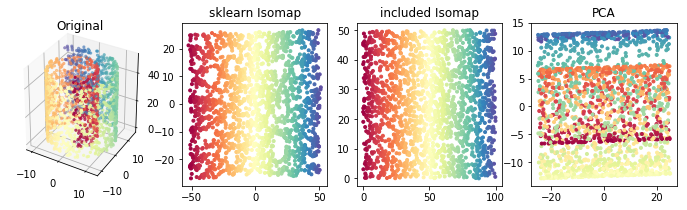

In [6]:
fig_raw = plt.figure(figsize=(12, 3))
#plot original data
ax1 = fig_raw.add_subplot(141, projection='3d')
ax1.scatter(swissX[0], swissX[1], swissX[2], marker='.', c=swissY[0], cmap=plt.cm.Spectral)
ax1.set_title('Original')
#plot our mapping
ax2 = fig_raw.add_subplot(142)
ax2.scatter(unrolledX[:,0],unrolledX[:,1],marker='.',c=swissY[0], cmap=plt.cm.Spectral)
ax2.set_title('sklearn Isomap')
#compare with mapping included in dataset
ax3 = fig_raw.add_subplot(143)
ax3.scatter(swissY[0],swissY[1],marker='.',c=swissY[0], cmap=plt.cm.Spectral)
ax3.set_title('included Isomap')
#compare with PCA
ax4 = fig_raw.add_subplot(144)
ax4.scatter(pcaX[:,0],pcaX[:,1],marker='.',c=swissY[0], cmap=plt.cm.Spectral)
ax4.set_title('PCA')
fig_raw.show()

In [48]:
#alternative
X, Y = make_swiss_roll(n_samples=4000) # Y is unrolled 1D coordinate

#takes a while
K = range(1, 4)
stress = []
for k in K:
    swissmap = Isomap(n_components=k, n_neighbors=10)
    swissmap.fit(X)
    stress.append(swissmap.reconstruction_error())

swissmap = Isomap(n_components=2, n_neighbors=10)
tX = swissmap.fit_transform(X)

/usr/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


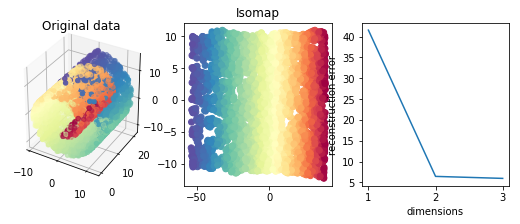

In [50]:
fig = plt.figure(figsize=(9, 3))

ax = fig.add_subplot(131, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=Y, cmap=plt.cm.Spectral)
ax.set_title("Original data")

ax = fig.add_subplot(132)
ax.scatter(tX[:, 0], tX[:, 1], c=Y, cmap=plt.cm.Spectral)
ax.set_title("Isomap")
ax = fig.add_subplot(133)
ax.plot(K, stress)
ax.set_xlabel('dimensions')
ax.set_ylabel('reconstruction error')
fig.show()

### Example 2: MNIST <a id='linkExample2'></a>

In [11]:
# include images in plot, code from:
# https://jakevdp.github.io/PythonDataScienceHandbook/05.10-manifold-learning.html
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray', zoom=1):
    ax = ax or plt.gca()
    
    proj = model.transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap, zoom=zoom),
                                      proj[i])
            ax.add_artist(imagebox)

In [34]:
# Load training + test data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("training data shape:", x_train.shape, y_train.shape)
print("test data shape:", x_test.shape, y_test.shape)

# choose a digit
# 0 width and rotation
# 1
# 2 bottom loop and top size?
# 3 rotation and bottom loop
# 4
# 5
# 6
# 7
# 8 ISOMAP shows rotation and loop size, PCA shows rotation and linewidth
# 9
X = x_train[:10000]
Y = y_train[:10000]
mask = [Y==8]
x = X[mask]
l = len(x)

# Flatten data elements from 28x28 array to 784-dim vector
x = x.reshape(l, 784)
print("flattened X shape:", x.shape)

training data shape: (60000, 28, 28) (60000,)
test data shape: (10000, 28, 28) (10000,)
flattened X shape: (944, 784)


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [35]:
t0 = time.perf_counter()
isomap = Isomap(n_components=2, n_neighbors=10)
modelISOMAP = isomap.fit(x)
total_time = time.perf_counter() - t0
print ("runtime:", total_time)
modelPCA = PCA(n_components = 2).fit(x)

runtime: 2.42105754899967


/usr/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


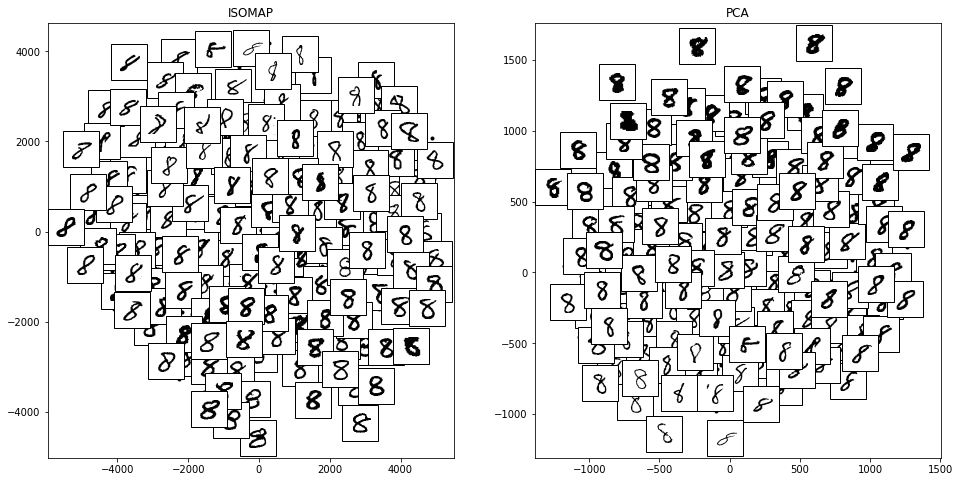

In [36]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
plot_components(x, modelISOMAP, images=x.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')
ax.set_title('ISOMAP')
ax = fig.add_subplot(122)
plot_components(x, modelPCA, images=x.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')
ax.set_title('PCA')
fig.show()

## Example 3: Faces <a id='linkExample3'></a>

In [37]:
# same face, illumination direction and camera angle are varied (4 features?)
#
#need to download and uncompress
#faces_url = 'https://web.archive.org/web/20150922051706/http://isomap.stanford.edu/face_data.mat.Z'
faces = loadmat('face_data.mat')
#print(faces.keys())
images = faces['images']
#print(images.shape) #64x64
#axes are flipped
x = np.transpose(images)
x = x.reshape(-1,64,64)
x = np.transpose(x, (0,2,1))
x = x.reshape(-1,64*64)

In [38]:
t0 = time.perf_counter()
isomap = Isomap(n_components=2, n_neighbors=10)
modelISOMAP = isomap.fit(x)
total_time = time.perf_counter() - t0
print ("runtime:", total_time)
modelPCA = PCA(n_components = 2).fit(x)

runtime: 5.80149735499981


/usr/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


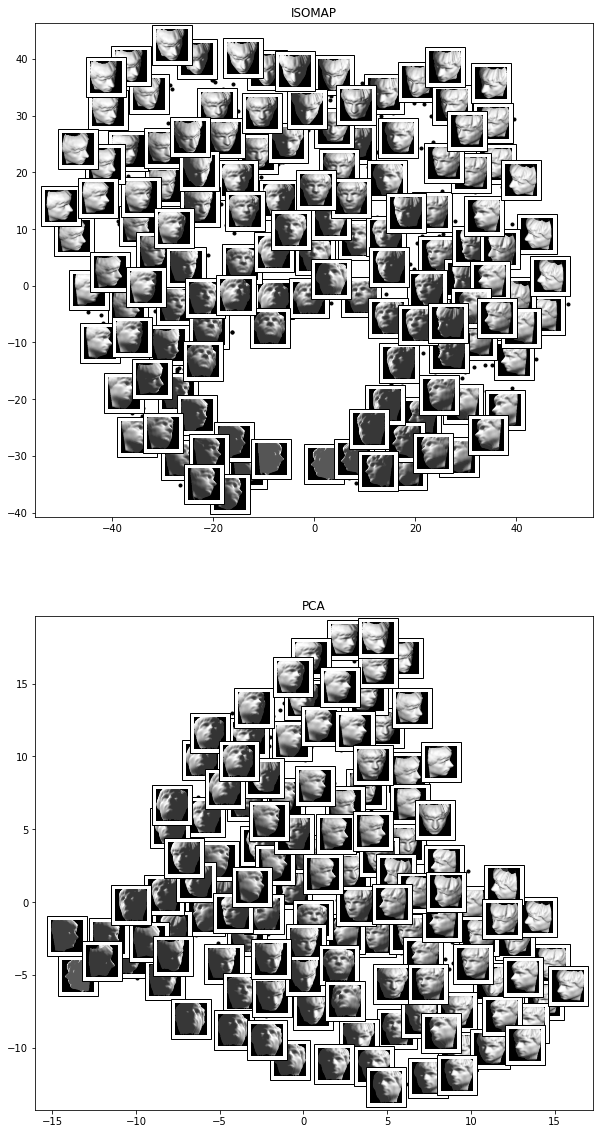

In [39]:
fig = plt.figure(figsize=(10,20))
ax = fig.add_subplot(211)
plot_components(x, modelISOMAP, images=x.reshape((-1, 64, 64)),
                ax=ax, thumb_frac=0.05, cmap='gray', zoom=0.5)
ax.set_title('ISOMAP')
ax = fig.add_subplot(212)
plot_components(x, modelPCA, images=x.reshape((-1, 64, 64)),
                ax=ax, thumb_frac=0.05, cmap='gray', zoom=0.5)
ax.set_title('PCA')
fig.show()

In [40]:
#more faces
from sklearn.datasets import fetch_lfw_people
GWBush = fetch_lfw_people(min_faces_per_person=500) #200MB
#2914=62x47 pixel images
x=GWBush.data
print(x.shape)

(530, 2914)


In [41]:
t0 = time.perf_counter()
isomap = Isomap(n_components=2, n_neighbors=10)
modelISOMAP = isomap.fit(x)
total_time = time.perf_counter() - t0
print ("runtime:", total_time)
modelPCA = PCA(n_components = 2).fit(x)

runtime: 2.8176777600001515


/usr/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


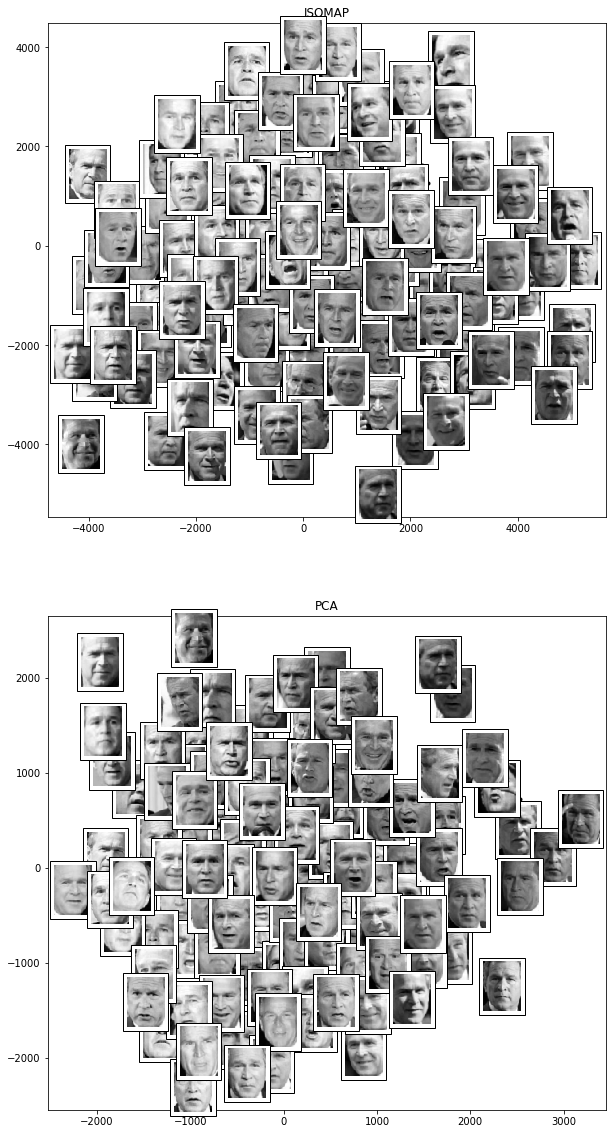

In [46]:
fig = plt.figure(figsize=(10, 20))
ax = fig.add_subplot(211)
plot_components(x, modelISOMAP, images=x.reshape((-1, 62, 47)),
                ax=ax, thumb_frac=0.05, cmap='gray', zoom=0.8)
ax.set_title('ISOMAP')
ax = fig.add_subplot(212)
plot_components(x, modelPCA, images=x.reshape((-1, 62, 47)),
                ax=ax, thumb_frac=0.05, cmap='gray', zoom=0.8)
ax.set_title('PCA')
fig.show()